# PINN for Frenet-Serret Plane curves

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#checking if device is gpu or cpu
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(str(device) + ': ' + torch.cuda.get_device_name(0))
else:
    print(device)

cuda: NVIDIA GeForce GTX 1060 6GB


In [3]:
#formulas for the helix = [1/k cos(sk), 1/k sin(sk)]
def v0(s,k):
    x=torch.cos(s*k)/k
    y=torch.sin(s*k)/k
    return([x,y])

#first derivative
def dv0(s,k):
    x=-torch.sin(s*k)
    y=torch.cos(s*k)
    return([x,y])

#second derivative
def d2v0(s,k):
    x=-torch.cos(s*k)*k
    y=-torch.sin(s*k)*k
    return([x,y])

#dummy function to create tensor batch of constant curvature k1 on domain
k1=1.
def k(s):
    y=k1*torch.exp(s*0)
    return(y)

#initial conditions
s1 = torch.tensor([[0.]],requires_grad=True,device=device)
vB = torch.tensor([v0(s1,k(s1))],requires_grad=True,device=device)
tB = torch.tensor([dv0(s1,k(s1))],requires_grad=True,device=device)
nB = torch.tensor([d2v0(s1,k(s1))],requires_grad=True,device=device)

print(f' vB={vB}\n tB={tB}\n nB={nB}')

 vB=tensor([[1., 0.]], device='cuda:0', requires_grad=True)
 tB=tensor([[-0., 1.]], device='cuda:0', requires_grad=True)
 nB=tensor([[-1., -0.]], device='cuda:0', requires_grad=True)


In [4]:
#setting up the model
w1=1.25
wh=1.
wk=1.5
n_epochs = 5850
batch_size = 85
lrate = 0.0001
nr = 350
domain = (-3.1,3.1)
sample_size=batch_size

modelsys = nn.Sequential(
    nn.Linear(1, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, 2))

loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)
modelsys = modelsys.to(device)


In [5]:
#training the model
import time
losstep = []
lossal = []
losskl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    s = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(s)
    v1 = v[:,0].reshape(batch_size,1)
    v2 = v[:,1].reshape(batch_size,1)
    dv1 = torch.autograd.grad(v1.sum(), s, create_graph=True)[0]
    d2v1 = torch.autograd.grad(dv1.sum(), s, create_graph=True)[0]
    dv2 = torch.autograd.grad(v2.sum(), s, create_graph=True)[0]
    d2v2 = torch.autograd.grad(dv2.sum(), s, create_graph=True)[0]
    norm = torch.sqrt(d2v1**2 + d2v2**2)
    
    dv_arc1 = dv1**2 + dv2**2 - 1
    k_residual = d2v1**2 + d2v2**2 - k(s)**2
    
    v_pred1 = modelsys(s1)
    bv = v_pred1 - vB
    dvxp = torch.autograd.grad(v_pred1[0][0].sum(), s1, create_graph=True)[0]
    dvyp = torch.autograd.grad(v_pred1[0][1].sum(), s1, create_graph=True)[0]
    d2vxp = torch.autograd.grad(dvxp.sum(), s1, create_graph=True)[0]
    d2vyp = torch.autograd.grad(dvyp.sum(), s1, create_graph=True)[0]
    
    
    bdv = dvxp + dvyp - tB[0][0] - tB[0][1]
    bd2v = d2vxp + d2vyp - nB[0][0] + nB[0][1]
    
    lossa = loss_fn(dv_arc1,torch.zeros_like(dv_arc1))
    lossk = loss_fn(k_residual,torch.zeros_like(k_residual))
    lossbv = loss_fn(bv,torch.zeros_like(bv))
    lossbdv = loss_fn(bdv,torch.zeros_like(bdv))
    lossbd2v = loss_fn(bd2v,torch.zeros_like(bd2v))
    lossbd = lossbv + lossbdv + lossbd2v
    
    loss = (w1*lossa + wh*(lossbv + lossbdv + lossbd2v) + wk*lossk)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossal.append(lossa.detach().cpu().numpy())
    losskl.append(lossk.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, k_loss: {lossk}, bd_loss: {lossbd}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')


Finished epoch 584 (10%), latest loss 0.004881117042081365, k_loss: 0.0026433135254545757, bd_loss: 3.4023754568446554e-05
Finished epoch 1169 (20%), latest loss 0.00032601669832785435, k_loss: 0.00015935426858175634, bd_loss: 2.993222904019635e-06
Finished epoch 1754 (30%), latest loss 0.00016596040493533075, k_loss: 8.774910029633489e-05, bd_loss: 1.796090273482733e-06
Finished epoch 2339 (40%), latest loss 3.563423982486478e-05, k_loss: 1.5237890894885551e-05, bd_loss: 2.1815675105972155e-06
Finished epoch 2924 (50%), latest loss 3.1681992238877756e-05, k_loss: 1.4214482734778984e-05, bd_loss: 1.498447183579598e-06
Finished epoch 3509 (60%), latest loss 3.3300461581729276e-05, k_loss: 9.539019634508696e-06, bd_loss: 8.856055762356747e-06
Finished epoch 4094 (70%), latest loss 6.075842347451334e-05, k_loss: 2.0090933410758922e-05, bd_loss: 1.4285930816921667e-05
Finished epoch 4679 (80%), latest loss 2.1728633668939887e-05, k_loss: 5.732608778856693e-06, bd_loss: 5.016205851402227e-0

Curvature accuracy: 0.00017537211533635855


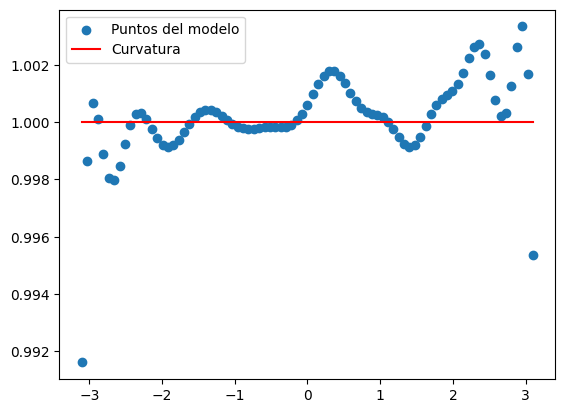

In [18]:
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
vi=modelsys(ti) #predicted curve

#getting derivatives to evaluate predicted curvature
vi1 = vi[:,0].reshape(batch_size,1)
vi2 = vi[:,1].reshape(batch_size,1)
dvi1 = torch.autograd.grad(vi1.sum(), ti, create_graph=True)[0]
d2v1 = torch.autograd.grad(dvi1.sum(), ti, create_graph=True)[0]
dvi2 = torch.autograd.grad(vi2.sum(), ti, create_graph=True)[0]
d2v2 = torch.autograd.grad(dvi2.sum(), ti, create_graph=True)[0]
kpred= torch.sqrt(d2v1**2 + d2v2**2)
ki=k(ti)
acck = (kpred - ki).float().mean() #mean accuracy of curvature
kpred=kpred.reshape(sample_size,1).detach().cpu().numpy()
ki=ki.reshape(sample_size,1).detach().cpu().numpy() #true curvature
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Curvature accuracy: {acck}')

plt.scatter(ti,kpred,label='Puntos del modelo')
plt.plot(ti,ki,color='r',label='Curvatura')
plt.legend()
plt.savefig('c1_curvature.png')
plt.show()

Accuracy: x1 -0.0023807904217392206, x2: 0.0014827767154201865


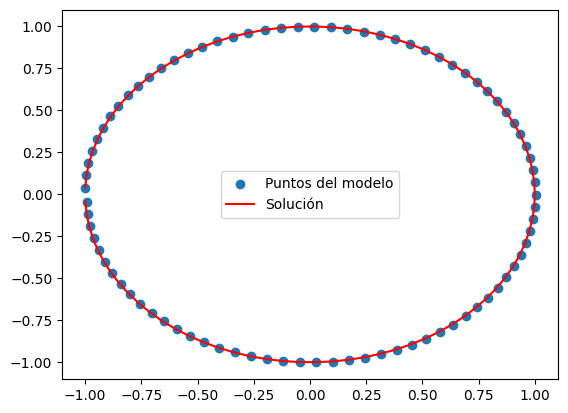

In [19]:
#verify true solution 
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
xi=vi[:,0]
yi=vi[:,1]
a0=v0(ti,k(ti))
accx = (a0[0] - xi).float().mean()
accy = (a0[1] - yi).float().mean()
a0[0]=a0[0].detach().cpu().numpy()
a0[1]=a0[1].detach().cpu().numpy()
xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Accuracy: x1 {accx}, x2: {accy}')
plt.scatter(xi,yi,label='Puntos del modelo')
plt.plot(a0[0],a0[1],label='Solución',color='r')
plt.legend()
plt.savefig('c1_solution.png')
plt.show()


Last loss: 1.820344608827598e-05


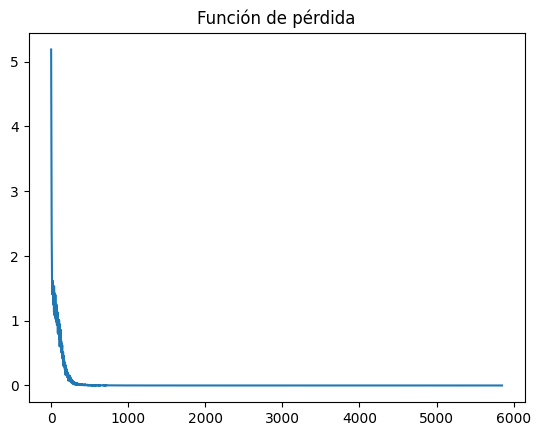

In [20]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Función de pérdida')
lastloss=losstep[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1_loss1.png')
plt.show()

Last loss: 4.728025701040892e-06


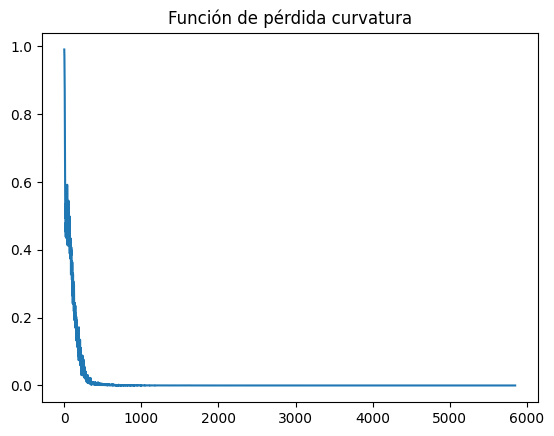

In [21]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losskl)
plt.title('Función de pérdida curvatura')
lastloss=losskl[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1_loss2.png')
plt.show()

Last loss: 6.346572250267764e-06


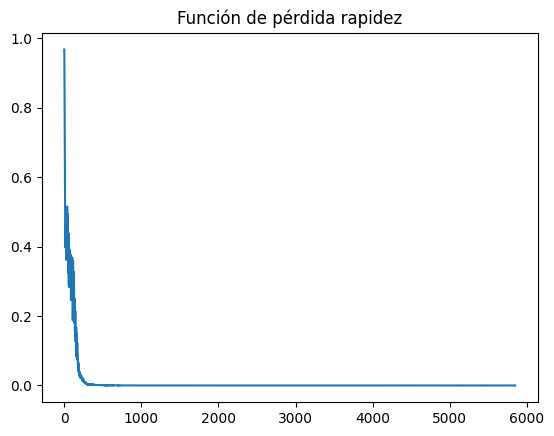

In [22]:
plt.plot(np.linspace(0,n_epochs,n_epochs),lossal)
plt.title('Función de pérdida rapidez')
lastloss=lossal[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1_loss3.png')
plt.show()

In [2]:
#formulas for the helix = [1/k cos(sk), 1/k sin(sk)]
def v0(s,k):
    x=torch.cos(s*k)/k
    y=torch.sin(s*k)/k
    return([x,y])

#first derivative
def dv0(s,k):
    x=-torch.sin(s*k)
    y=torch.cos(s*k)
    return([x,y])

#second derivative
def d2v0(s,k):
    x=-torch.cos(s*k)*k
    y=-torch.sin(s*k)*k
    return([x,y])

#curvature of a parabola y=x**2
def k(s):
    y=2/torch.sqrt((1+4*s**2)**3)
    return(y)

#initial conditions
s1 = torch.tensor([[0.]],requires_grad=True,device=device)
vB = torch.tensor([v0(s1,k(s1))],requires_grad=True,device=device)
tB = torch.tensor([dv0(s1,k(s1))],requires_grad=True,device=device)
nB = torch.tensor([d2v0(s1,k(s1))],requires_grad=True,device=device)

print(f' vB={vB}\n tB={tB}\n nB={nB}')

 vB=tensor([[0.5000, 0.0000]], device='cuda:0', requires_grad=True)
 tB=tensor([[-0., 1.]], device='cuda:0', requires_grad=True)
 nB=tensor([[-2., -0.]], device='cuda:0', requires_grad=True)


In [3]:
#setting up the model
w1=1.25
wh=1.
wk=1.5
n_epochs = 8850
batch_size = 85
lrate = 0.0001
nr = 350
domain = (-1.5,1.5)
sample_size=batch_size

modelsys = nn.Sequential(
    nn.Linear(1, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, 2))

loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)
modelsys = modelsys.to(device)


In [4]:
#training the model for the parabola y=x**2
import time
losstep = []
lossal = []
losskl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    s = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(s)
    v1 = v[:,0].reshape(batch_size,1)
    v2 = v[:,1].reshape(batch_size,1)
    dv1 = torch.autograd.grad(v1.sum(), s, create_graph=True)[0]
    d2v1 = torch.autograd.grad(dv1.sum(), s, create_graph=True)[0]
    dv2 = torch.autograd.grad(v2.sum(), s, create_graph=True)[0]
    d2v2 = torch.autograd.grad(dv2.sum(), s, create_graph=True)[0]
    norm = torch.sqrt(d2v1**2 + d2v2**2)
    
    dv_arc1 = dv1**2 + dv2**2 - 1
    k_residual = d2v1**2 + d2v2**2 - k(s)**2
    
    v_pred1 = modelsys(s1)
    bv = v_pred1 - vB
    dvxp = torch.autograd.grad(v_pred1[0][0].sum(), s1, create_graph=True)[0]
    dvyp = torch.autograd.grad(v_pred1[0][1].sum(), s1, create_graph=True)[0]
    d2vxp = torch.autograd.grad(dvxp.sum(), s1, create_graph=True)[0]
    d2vyp = torch.autograd.grad(dvyp.sum(), s1, create_graph=True)[0]
    
    
    bdv = dvxp + dvyp - tB[0][0] - tB[0][1]
    bd2v = d2vxp + d2vyp - nB[0][0] + nB[0][1]
    
    lossa = loss_fn(dv_arc1,torch.zeros_like(dv_arc1))
    lossk = loss_fn(k_residual,torch.zeros_like(k_residual))
    lossbv = loss_fn(bv,torch.zeros_like(bv))
    lossbdv = loss_fn(bdv,torch.zeros_like(bdv))
    lossbd2v = loss_fn(bd2v,torch.zeros_like(bd2v))
    lossbd = lossbv + lossbdv + lossbd2v
    
    loss = (w1*lossa + wh*(lossbv + lossbdv + lossbd2v) + wk*lossk)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossal.append(lossa.detach().cpu().numpy())
    losskl.append(lossk.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, k_loss: {lossk}, bd_loss: {lossbd}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')


Finished epoch 884 (10%), latest loss 0.0008388935509568364, k_loss: 0.00034945074634394407, bd_loss: 1.5934451832483704e-05
Finished epoch 1769 (20%), latest loss 0.00034396061594121153, k_loss: 0.00015305352071887034, bd_loss: 2.0372727462402685e-05
Finished epoch 2654 (30%), latest loss 0.00014275744054741244, k_loss: 5.524187987028535e-05, bd_loss: 7.531087293798628e-06
Finished epoch 3539 (40%), latest loss 0.00043411576040715516, k_loss: 0.0001272557720595372, bd_loss: 0.00019015167114443338
Finished epoch 4424 (50%), latest loss 7.450184867277445e-05, k_loss: 2.1876695977233393e-05, bd_loss: 2.4094072036587948e-05
Finished epoch 5309 (60%), latest loss 5.1481678294235114e-05, k_loss: 1.319338916377486e-05, bd_loss: 8.502810506527715e-06
Finished epoch 6194 (70%), latest loss 2.1988791940184736e-05, k_loss: 6.480534804963528e-06, bd_loss: 1.7332082851471843e-06
Finished epoch 7079 (80%), latest loss 0.00021984871044986642, k_loss: 3.724951720834015e-05, bd_loss: 8.331189663576729

Curvature accuracy: 0.0003459878789726645


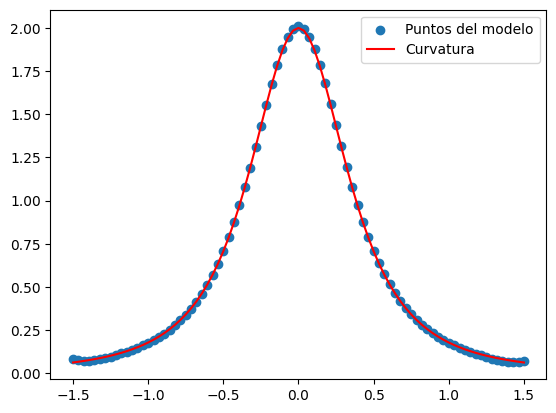

In [9]:
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
vi=modelsys(ti) #predicted curve

#getting derivatives to evaluate predicted curvature
vi1 = vi[:,0].reshape(batch_size,1)
vi2 = vi[:,1].reshape(batch_size,1)
dvi1 = torch.autograd.grad(vi1.sum(), ti, create_graph=True)[0]
d2v1 = torch.autograd.grad(dvi1.sum(), ti, create_graph=True)[0]
dvi2 = torch.autograd.grad(vi2.sum(), ti, create_graph=True)[0]
d2v2 = torch.autograd.grad(dvi2.sum(), ti, create_graph=True)[0]
kpred= torch.sqrt(d2v1**2 + d2v2**2)
ki=k(ti)
acck = (kpred - ki).float().mean() #mean accuracy of curvature
kpred=kpred.reshape(sample_size,1).detach().cpu().numpy()
ki=ki.reshape(sample_size,1).detach().cpu().numpy() #true curvature
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Curvature accuracy: {acck}')

plt.scatter(ti,kpred,label='Puntos del modelo')
plt.plot(ti,ki,color='r',label='Curvatura')
plt.legend()
plt.savefig('p1_curvature.png')
plt.show()

Accuracy: -0.2675440311431885


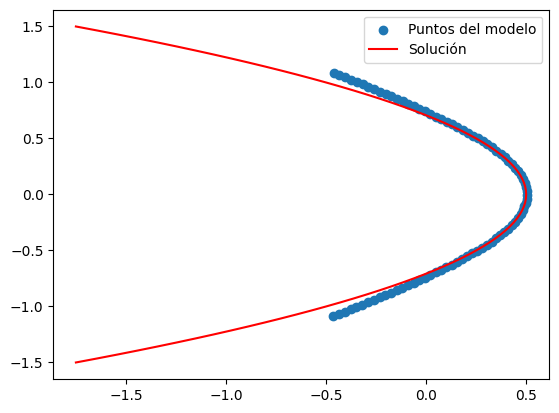

In [17]:
#verify true solution 
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
xi=vi[:,0]
yi=vi[:,1]
a0=-ti*ti+.5
accy = (a0 - yi).float().mean()
a0=a0.detach().cpu().numpy()
xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Accuracy: {accy}')
plt.scatter(xi,yi,label='Puntos del modelo')
plt.plot(a0,ti,label='Solución',color='r')
plt.legend()
plt.savefig('p1_solution.png')
plt.show()

Last loss: 0.0001123569201577108


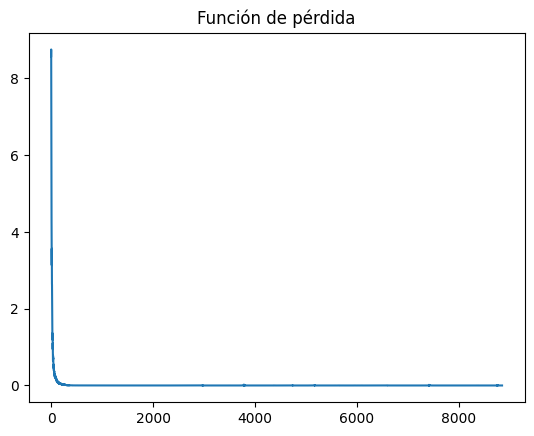

In [18]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Función de pérdida')
lastloss=losstep[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('p1_loss1.png')
plt.show()

Last loss: 3.40726177863777e-05


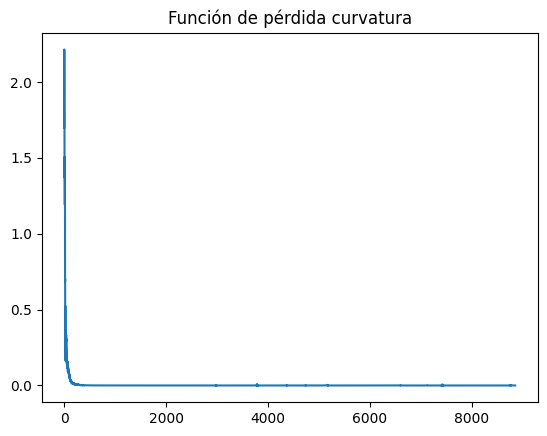

In [19]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losskl)
plt.title('Función de pérdida curvatura')
lastloss=losskl[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('p1_loss2.png')
plt.show()

Last loss: 9.708921204880223e-06


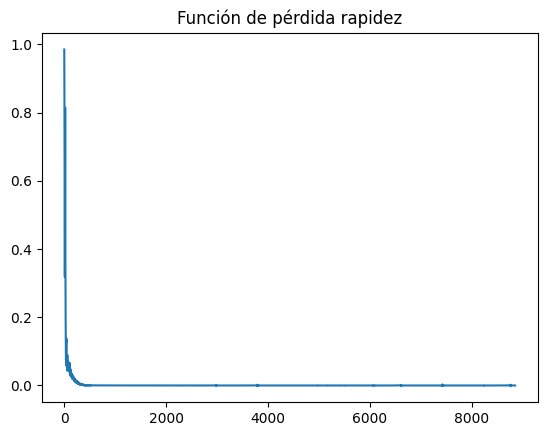

In [20]:
plt.plot(np.linspace(0,n_epochs,n_epochs),lossal)
plt.title('Función de pérdida rapidez')
lastloss=lossal[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('p1_loss3.png')
plt.show()

In [7]:
#formulas for the helix = [1/k cos(sk), 1/k sin(sk)]
def v0(s,k):
    x=torch.cos(s*k)/k
    y=torch.sin(s*k)/k
    return([x,y])

#first derivative
def dv0(s,k):
    x=-torch.sin(s*k)
    y=torch.cos(s*k)
    return([x,y])

#second derivative
def d2v0(s,k):
    x=-torch.cos(s*k)*k
    y=-torch.sin(s*k)*k
    return([x,y])

#curvature for th euler or cornu spiral
def k(s):
    y=s
    return(y)

#initial conditions
s1 = torch.tensor([[1.5]],requires_grad=True,device=device)
vB = torch.tensor([v0(s1,k(s1))],requires_grad=True,device=device)
tB = torch.tensor([dv0(s1,k(s1))],requires_grad=True,device=device)
nB = torch.tensor([d2v0(s1,k(s1))],requires_grad=True,device=device)

print(f' vB={vB}\n tB={tB}\n nB={nB}')

 vB=tensor([[-0.4188,  0.5187]], device='cuda:0', requires_grad=True)
 tB=tensor([[-0.7781, -0.6282]], device='cuda:0', requires_grad=True)
 nB=tensor([[ 0.9423, -1.1671]], device='cuda:0', requires_grad=True)


In [8]:
#setting up the model
wx=1.25
wy=1
wb=1.
wk=1.5
n_epochs = 35850
batch_size = 85
lrate = 0.0001
nr = 250
domain = (0.75,4.75)
sample_size=batch_size

modelsys = nn.Sequential(
    nn.Linear(1, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, 2))

loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)
modelsys = modelsys.to(device)

In [9]:
#training the model
import time
losstep = []
lossal = []
lossd2l = []
losskl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    s = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(s)
    v1 = v[:,0].reshape(batch_size,1)
    v2 = v[:,1].reshape(batch_size,1)
    dv1 = torch.autograd.grad(v1.sum(), s, create_graph=True)[0]
    d2v1 = torch.autograd.grad(dv1.sum(), s, create_graph=True)[0]
    dv2 = torch.autograd.grad(v2.sum(), s, create_graph=True)[0]
    d2v2 = torch.autograd.grad(dv2.sum(), s, create_graph=True)[0]
    norm = torch.sqrt(d2v1**2 + d2v2**2)
    
    dv_arc1 = dv1**2 + dv2**2 - 1
    k_residual = d2v1**2 + d2v2**2 - k(s)**2
    
    v_pred1 = modelsys(s1)
    bv = v_pred1 - vB
    dvxp = torch.autograd.grad(v_pred1[0][0].sum(), s1, create_graph=True)[0]
    dvyp = torch.autograd.grad(v_pred1[0][1].sum(), s1, create_graph=True)[0]
    d2vxp = torch.autograd.grad(dvxp.sum(), s1, create_graph=True)[0]
    d2vyp = torch.autograd.grad(dvyp.sum(), s1, create_graph=True)[0]
    
    bdv = dvxp + dvyp - tB[0][0] - tB[0][1]
    bd2v = d2vxp + d2vyp - nB[0][0] + nB[0][1]
    
    lossa = loss_fn(dv_arc1,torch.zeros_like(dv_arc1))
    lossk = loss_fn(k_residual,torch.zeros_like(k_residual))
    lossbv = loss_fn(bv,torch.zeros_like(bv))
    lossbdv = loss_fn(bdv,torch.zeros_like(bdv))
    lossbd2v = loss_fn(bd2v,torch.zeros_like(bd2v))
    lossbd = lossbv + lossbdv + lossbd2v
    
    loss = (wx*lossa + wb*(lossbv + lossbdv + lossbd2v) + wk*lossk)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossal.append(lossa.detach().cpu().numpy())
    losskl.append(lossk.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, k_loss: {lossk}, bd_loss: {lossbd}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 3584 (10%), latest loss 0.04017700731513777, k_loss: 0.004121714905707909, bd_loss: 0.0012004414792043637
Finished epoch 7169 (20%), latest loss 0.0216801152845078, k_loss: 0.004872080544865816, bd_loss: 0.0007228052331384874
Finished epoch 10754 (30%), latest loss 0.010340912924126353, k_loss: 0.0017152325130876834, bd_loss: 0.0008244286914647249
Finished epoch 14339 (40%), latest loss 0.011254321691759786, k_loss: 0.003325073567608414, bd_loss: 0.00021072446840269822
Finished epoch 17924 (50%), latest loss 0.008964088040843227, k_loss: 0.003036483393240668, bd_loss: 0.00010551029370235341
Finished epoch 21509 (60%), latest loss 0.00787323906552586, k_loss: 0.0036501351289772565, bd_loss: 0.00015007159552274537
Finished epoch 25094 (70%), latest loss 0.01070184204747359, k_loss: 0.005482033914534485, bd_loss: 0.00027437994872373764
Finished epoch 28679 (80%), latest loss 0.017535071317271327, k_loss: 0.008793462971703506, bd_loss: 0.0005622726925384105
Finished epoch 32

Curvature accuracy: 0.001589678693562746


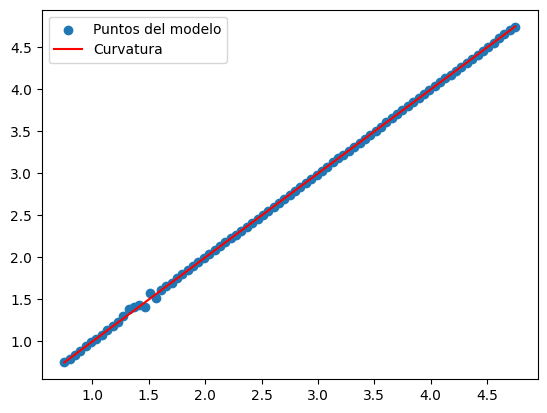

In [10]:
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
vi=modelsys(ti) #predicted curve

#getting derivatives to evaluate predicted curvature
vi1 = vi[:,0].reshape(batch_size,1)
vi2 = vi[:,1].reshape(batch_size,1)
dvi1 = torch.autograd.grad(vi1.sum(), ti, create_graph=True)[0]
d2v1 = torch.autograd.grad(dvi1.sum(), ti, create_graph=True)[0]
dvi2 = torch.autograd.grad(vi2.sum(), ti, create_graph=True)[0]
d2v2 = torch.autograd.grad(dvi2.sum(), ti, create_graph=True)[0]
kpred= torch.sqrt(d2v1**2 + d2v2**2)
ki=k(ti)
acck = (kpred - ki).float().mean() #mean accuracy of curvature
kpred=kpred.reshape(sample_size,1).detach().cpu().numpy()
ki=ki.reshape(sample_size,1).detach().cpu().numpy() #true curvature
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Curvature accuracy: {acck}')

plt.scatter(ti,kpred,label='Puntos del modelo')
plt.plot(ti,ki,color='r',label='Curvatura')
plt.legend()
plt.savefig('e1_curvature.png')
plt.show()

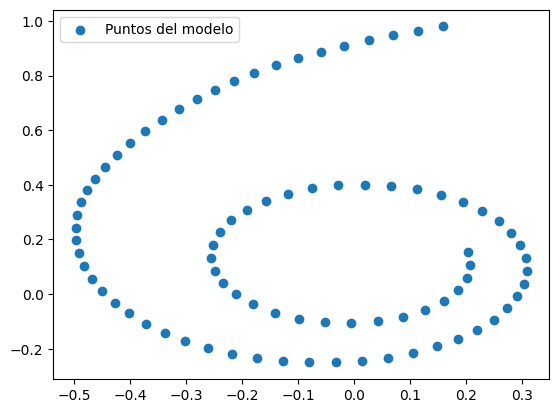

In [19]:
#plot of model points
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
xi=vi[:,0]
yi=vi[:,1]
xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
plt.scatter(xi,yi,label='Puntos del modelo')
plt.legend()
plt.savefig('e1_solution.png')
plt.show()

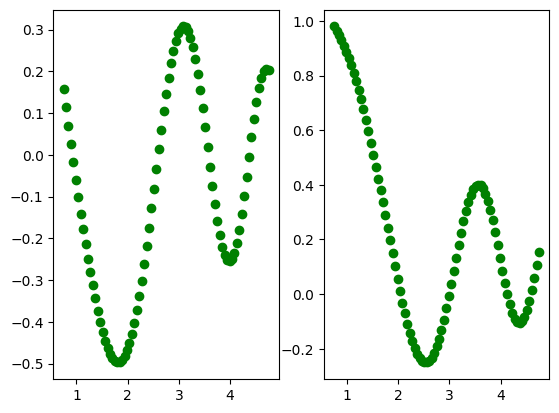

In [13]:
#plot of coordinates x(s),y(s)
figure, axis = plt.subplots(1, 2)
axis[0].scatter(ti,xi,color='g')
axis[1].scatter(ti,yi,color='g')
plt.savefig('e1_xysolution.png')
plt.show()

Last loss: 0.004118130055481254


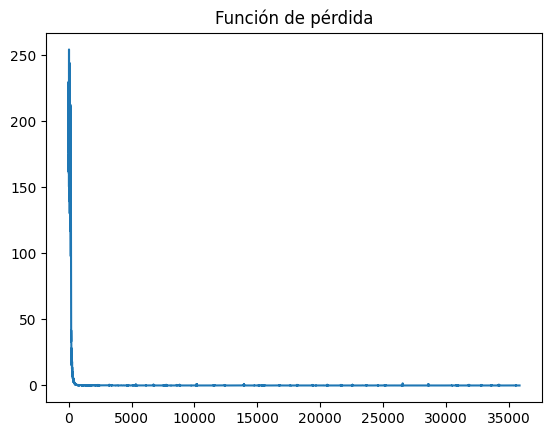

In [15]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Función de pérdida')
lastloss=losstep[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('e1_loss1.png')
plt.show()

Last loss: 0.0015317983394545571


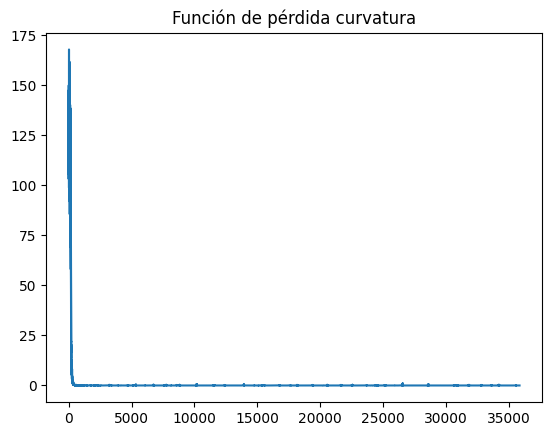

In [16]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losskl)
plt.title('Función de pérdida curvatura')
lastloss=losskl[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('e1_loss2.png')
plt.show()

Last loss: 0.0007651633839152152


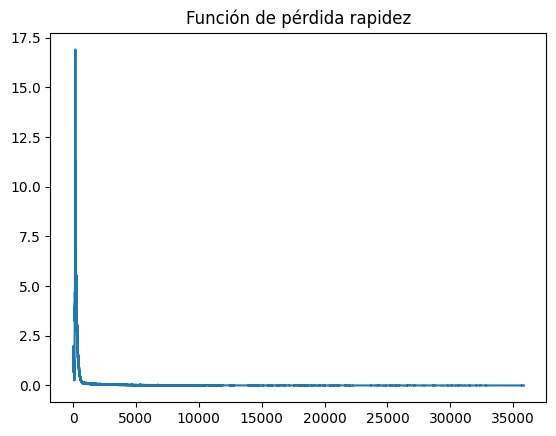

In [17]:
plt.plot(np.linspace(0,n_epochs,n_epochs),lossal)
plt.title('Función de pérdida rapidez')
lastloss=lossal[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('e1_loss3.png')
plt.show()